In [50]:
import os
import json
from glob import glob
from collections import Counter
import sys
sys.path.insert(0, '../')

import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from modules.load_data import load

read 데이터로부터 유저가 조회한 글들을 시퀀스 형태로 받아볼 수 있음.  
시퀀스를 바탕으로 그래프를 그려보면 각각의 글 간에 관계성을 구해볼 수 있지 않을까?  
metadata에서는 post_id에 따른 태그 목록(keyword_list)를 얻어볼 수 있음  
그래프를 그릴 수 있다면, 각 post_id의 태그 정보를 attribute로 삼아 GNN을 구현할 수 있지 않을까?

In [13]:
read = load(name='read')
post_sequences = read['sequence'].tolist()

metadata의 keyword_list를 활용한 태그 간 유사성 파악
- TF-IDF 활용
- 작가별 character를 알아볼 수도 있겠는데?

In [75]:
metadata_raw = load('metadata')

In [86]:
metadata_kwd = metadata_raw[metadata_raw['keyword_list'].apply(lambda x: len(x) > 0)].reset_index(drop=True)['keyword_list']

In [93]:
def squeeze(arr: list) -> list:
    '''2차원 리스트를 1차원으로 squeeze'''
    result = []
    for l in arr:
        if len(l) > 0 and isinstance(l, list):
            result.extend(l)
        elif not isinstance(l, list):
            result.append(l)
    return result
        
print(f'태그 종류 수: {len(set(squeeze(metadata_kwd.tolist()))):,d}')

태그 종류 수: 86,037


In [97]:
kwd_frequency = pd.Series(Counter(squeeze(metadata_kwd))).sort_values(ascending=False)

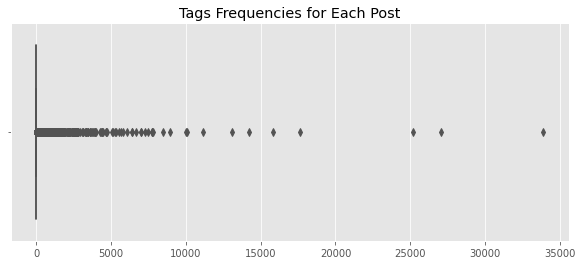

In [104]:
plt.figure(figsize=(10, 4))
sns.boxplot(kwd_frequency.values)
plt.title('Tags Frequencies for Each Post')
plt.show()

In [113]:
kwd_cumul_freq = kwd_frequency.to_frame('freq')[::-1].cumsum().reset_index()

In [121]:
kwd_density = kwd_frequency / kwd_frequency.sum()

In [124]:
kwd_cumul_density = kwd_density.to_frame('density')[::-1].cumsum().reset_index()

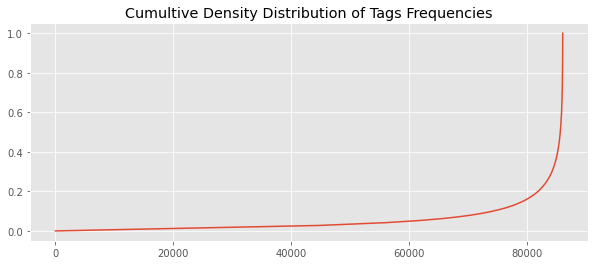

In [130]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=kwd_cumul_density.index.tolist(), y=kwd_cumul_density['density'].tolist())
plt.title('Cumultive Density Distribution of Tags Frequencies')
plt.show()

In [153]:

TOP_N = 7000
print(f'상위 {TOP_N}개 태그가 전체 태그 중 차지하는 비율: {kwd_frequency.head(TOP_N).sum() / kwd_frequency.sum()}')


상위 7000개 태그가 전체 태그 중 차지하는 비율: 0.8536076380940615


7000개 태그를 활용하여 TF-IDF를 산출해봅시다

In [157]:
vocabulary = kwd_frequency.head(7000).index.tolist()

In [161]:
def filter_tags(tag_list: list, vocabulary: list) -> list:
    '''metadata 내 태그 리스트(keyword_list)의 태그 목록 중 vocabulary에 있는 태그만을 남기고 나머지는 제거하는 함수
    metadata['keyword_list'].apply(lambda x: filter_tags(x, vocabulary))
    '''
    result = []
    for tag in tag_list:
        if tag in vocabulary:
            result.append(tag)
    return result

In [169]:
metadata_kwd_filtered = metadata_kwd.apply(lambda x: filter_tags(x, vocabulary))

In [174]:
metadata_kwd_filtered[metadata_kwd_filtered.apply(lambda x: len(x) == 0)]

103       []
164       []
227       []
253       []
257       []
          ..
572777    []
572836    []
572845    []
572998    []
573028    []
Name: keyword_list, Length: 11152, dtype: object

In [178]:
metadata_kwd_filtered.to_frame().to_csv('../raw/metadata_kwd_list_vocab7000.csv', index=False)